In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

# Get the data this is from the sample code
# The data is in TSVs with three columns
#    time (mjd?)    v_r     err_vr
data1 = np.loadtxt("HARPS.dat")
data2 = np.loadtxt("HIRES.dat")
print(len(data1), ' HARPS points; ', len(data2), ' HIRES points')

# Transpose the data for contiguity reasons
data = np.hstack((data1.T, data2.T)).copy("C")

# Add on jitter (additional noise term)
# This term adds a fixed amount to the variances of each term to
# account for intrinsic noise not associated with the detector.
# Detector-related uncertainties are expressed in the third row
# already (data[2])
jitter = 1.2
data[2] = np.sqrt(data[2]**2 + jitter**2)

# Initial information from Vogt et al. (2010)
Pb_sol = 5.36841; Pb_del = 0.00026; Kb_sol = 12.45
Pc_sol = 12.9191; Pc_del = 0.0058;  Kc_sol = 3.30
Pd_sol = 66.87;   Pd_del = 0.13;    Kd_sol = 1.91
Pe_sol = 3.14867; Pe_del = 0.00039; Ke_sol = 1.66
Pf_sol = 433.0;   Pf_del = 13.0;    Kf_sol = 1.30
Pg_sol = 36.562;  Pg_del = 0.052;   Kg_sol = 1.29

119  HARPS points;  122  HIRES points


In [2]:
# Since we'll be using these numbers a lot, let's move the data from
# hard coded variables into a DataFrame we can manipulate easier
df_sol = pd.DataFrame(
    (
        (Pb_sol, Pb_del, Kb_sol),
        (Pc_sol, Pc_del, Kc_sol),
        (Pd_sol, Pd_del, Kd_sol),
        (Pe_sol, Pe_del, Ke_sol),
        (Pf_sol, Pf_del, Kf_sol),
        (Pg_sol, Pg_del, Kg_sol)
    ),
    columns=["P", "P_del", "K"],
    index=["b", "c", "d", "e", "f", "g"]
)
df_sol

,P,P_del,K
b,5.36841,0.00026,12.45
c,12.91910,0.00580,3.30
d,66.87000,0.13000,1.91
e,3.14867,0.00039,1.66
f,433.00000,13.00000,1.30
g,36.56200,0.05200,1.29


In [3]:
# Define the model M0 with the confirmed planets b, c, d, e
df_M0 = df_sol.loc[["b", "c", "d", "e"]]

# Define the model Mf with the confirmed planets b, c, d, e and f
df_Mf = df_sol.loc[["b", "c", "d", "e", "f"]]

# Define the model Mf with the confirmed planets b, c, d, e and g
df_Mg = df_sol.loc[["b", "c", "d", "e", "g"]]

# Define the model Mf with the confirmed planets b, c, d, e and both f and g
df_Mfg = df_sol.loc[["b", "c", "d", "e", "f", "g"]]


# Definitely incorrect models
# Include these to make sure our calculated statistics make sense, they should
# perform much worse than M_0
df_Mbc = df_sol.loc[["b", "c"]]
df_Mbcd = df_sol.loc[["b", "c", "d"]]

In [4]:
# A full fit is tricky because it's not obvious where to initalize the phases (q) from
# So let's run a pre-fit first, where we only allow the phases to vary
# Trying running this a few times and make sure the same solution is coming out

# I make the fitting functions re-usable for the three cases we're considering by removing
# anything hard coding the functions to specific planets

# Define the constant 2*pi since we're using it a lot
_2PI = 2. * np.pi 

# the least_squares method in scipy defines various tolerances that allow us
# to tune how much precision we want in our fit.

# For the large MC ensemble, high precision is not necessary and we can save a lot of time
# by defining more lenient tolerances
MC_TOLS = dict(
    ftol=1e-05,
    xtol=1e-05,
    gtol=1e-05,
)

# These are the default tolerances in scipy
DEFAULT_TOLS = dict(
    ftol=1e-08,
    xtol=1e-08,
    gtol=1e-08,
)

# Define model Mfix = N model using K & P parameters fixed to the Vogt+ reported values
# Fits to all planets in df. Ensure that the array q has the same length as df.
def Mfix(df):
    K = df["K"].to_numpy().reshape(1, -1)
    P = df["P"].to_numpy().reshape(1, -1)

    # @ngjit
    def _Mfix(t, *args):
        return np.sum(K * np.sin(_2PI * np.reshape(t, (-1, 1)) / P + np.asarray(args)), axis=1)
    return _Mfix

# This function performs the curve fit for the phases based on the model "Mfix"
# returned by the function above
def fix_phases(n_p, Mfix, data=data, tols=DEFAULT_TOLS):
    # Define our parameters bounds
    param_bounds = (
        np.full(n_p, -_2PI),
        np.full(n_p,  _2PI),
    )

    # Give an intial guess to help the fitting routine
    initial_guess = np.random.uniform(-_2PI, _2PI, size=n_p)
    # Doing the curve fit
    Mfix_best, _ = curve_fit(Mfix,
        data[0], data[1], sigma=data[2],
        p0=initial_guess, bounds=param_bounds, **tols)

    modeled = Mfix(data[0], *Mfix_best)

    # returns the parameters and the model at each data point
    return Mfix_best, modeled

In [5]:
# Like in the sample code, calculate initial fits for the phases and the corresponding
# chi^2 to check that it is working
M0_phases, M0_phase_fix_fit = fix_phases(len(df_M0), Mfix(df_M0), data)

# Calculate chi^2 from the residuals and the reported errors on the velocities
chi2 = np.sum(((data[1] - M0_phase_fix_fit) / data[2])**2)

# Print output
print(chi2, len(data))

395.79612572654395 3


In [6]:
# Now we're ready to run the full N-planet fit

# This function will work for any number of planets, so we don't need to define
# new model functions.

# As in the example code, treat every three elements of args as (Ki, Pi, qi)
# using some reshaping magic
def M(t, *args):
    K, P, q = np.reshape(np.asarray(args), (-1, 1, 3)).T
    return np.sum(K * np.sin(_2PI * np.reshape(t, (-1, 1)) / P + q), axis=1)

# I separated out the code for initializing the parameter boundaries since
# we don't need to recalculate for each fit with a model when we do the
# full cross-validation model selection
def full_fit_param_bounds(df_model):
    # curve_fit expects a (3*n_p, 2) array, where we've flattened the parameters
    # into [(K_1, P_1, Q_1, K_2, P_2, Q_2...), (K_1, P_1, Q_1, K_2, P_2, Q_2...)]
    param_bounds = np.empty((2, len(df_model)*3), dtype=np.float64)

    # We transpose and and reshape the array to create a view
    # where we can set each parameter K, Q, and P with a n_p x 3 x 2
    # input array, which is more natural for bounds
    param_bounds_S = param_bounds.T.reshape(-1, 3, 2)

    # K bounds
    param_bounds_S[:, 0, :] = (0., 20.)
    # P bounds (+/- 3 sigma)
    param_bounds_S[:, 1, :] = np.transpose([
        df_model["P"] - 3. * df_model["P_del"],
        df_model["P"] + 3. * df_model["P_del"]
    ])

    # q bounds
    param_bounds_S[:, 2, :] = (-_2PI, _2PI)

    return param_bounds

# This function performs the full fit for K, P and q based on initial guesses from
# the data frame df_model and the pre-fit phases q.
# param_bounds can be optionally supplied by the caller (to avoid recalculating it)
def full_fit(df_model, q, data=data, param_bounds=None, tols=DEFAULT_TOLS):
    if param_bounds is None:
        param_bounds = full_fit_param_bounds(df_model)

    # Give an intial guess to help the fitting routine
    # Initialize it as a N x 3 array, and ravel/flatten it when
    # we pass it to curve_fit. The rows are K, P, and q
    initial_guess = np.empty((len(df_model), 3), dtype=np.float64)
    initial_guess[:, 0] = df_model["K"].to_numpy()
    initial_guess[:, 1] = df_model["P"].to_numpy()
    initial_guess[:, 2] = q

    # Get the best fitting parameters
    M_best, _ = curve_fit(M,
        data[0], data[1], sigma=data[2],
        p0=initial_guess.ravel(), bounds=param_bounds, **tols)

    modeled = M(data[0], *M_best)

    # returns the parameters and the model at each data point
    return M_best, modeled

In [7]:
# Like in the sample code, calculate initial fits on M0 and the corresponding
# chi^2 to check that it is working
M0_best, M0_fit = full_fit(df_M0, M0_phases, data, tols=MC_TOLS)

# Get the chi2
chi2 = np.sum(((data[1] - M0_fit) / data[2])**2)

# Get the loglike
loglike = -0.5*data.shape[1]*np.log(_2PI) - np.sum(np.log(data[2])) - 0.5*chi2

# print the chi2 and loglike
print(chi2, loglike)

390.39474532529493 -567.779672548716


In [8]:
# From Nitya, functions to calculate various model comparison metrics from
# the chi^2, n (number of data points) and k (number of free parameters in model)

# Refer to the lecture slides for the source of the formulas

def reduced_chi2(chi2, n, k):
    return chi2 / (n - k)

def BIC(chi2, n, k):
    return chi2 + k * np.log(n)

def AIC(chi2, k):
    return chi2 + 2 * k

def mod_AIC(chi2, n, k):
    return AIC(chi2, k) + (2*k**2 + 2*k)/(n - k - 1)

def BIC_bayes(bic1, bic2):
    return np.exp(-0.5*(bic1-bic2))

In [12]:
# For a certain model with pre-determined parameter guesses in the dataframe df_model,
# performs the fit shown above on the data in data_train, and returns various metrics
# of model performance on data_val as a dictionary.
def eval_all_model(df_model, data_train, data_val):
    # Do the phase pre-fit
    q, _= fix_phases(len(df_model), Mfix(df_model), data_train)
    # Fit all the parameters
    best_fit, _ = full_fit(df_model, q, data_train)

    # Compute the chi^2 and log likelihood as above
    chi2 = np.sum(((data_val[1] - M(data_val[0], *best_fit)) / data_val[2])**2)
    loglike = -0.5*data_val.shape[1]*np.log(_2PI) - np.sum(np.log(data_val[2])) - 0.5*chi2

    # n (number of data points) and k (number of free parameters in model)
    n = data_val.shape[1]
    k = len(df_model) * 3
    return {
        "chi2": chi2,
        "loglike": loglike,
        "reduced_chi2": reduced_chi2(chi2, n, k),
        "BIC": BIC(chi2, n, k),
        "AIC": AIC(chi2, k),
        "mod_AIC": mod_AIC(chi2, n, k),
    }

# Make a dataframe for the table to be displayed on the presentation
df_compare = pd.DataFrame({
    "$M_{bc}$": eval_all_model(df_Mbc, data, data),
    "$M_{bcd}$": eval_all_model(df_Mbcd, data, data),
    "$M_0$": eval_all_model(df_M0, data, data),
    "$M_f$": eval_all_model(df_Mf, data, data),
    "$M_g$": eval_all_model(df_Mg, data, data),
    "$M_{fg}$": eval_all_model(df_Mfg, data, data)
}).transpose()
df_compare

,chi2,loglike,reduced_chi2,BIC,AIC,mod_AIC
$M_{bc}$,600.181270,-672.672935,2.553963,633.090051,612.181270,612.540244
$M_{bcd}$,491.288316,-618.226458,2.117622,540.651488,509.288316,510.067537
$M_0$,390.531408,-567.848004,1.705377,456.348971,414.531408,415.899829
$M_f$,346.568249,-545.866424,1.533488,428.840203,376.568249,378.701582
$M_g$,341.941847,-543.553223,1.513017,424.213801,371.941847,374.075180
$M_{fg}$,297.629780,-521.397190,1.334663,396.356125,333.629780,336.710861


In [13]:
# Print out the table in LaTeX for the presentation. I fed this with
# some edits through a tool to convert LaTeX to transparent PNG
print(df_compare.style.format(precision=2)
      .format_index(escape="latex", axis=1)
      .to_latex())

\begin{tabular}{lrrrrrr}
 & chi2 & loglike & reduced\_chi2 & BIC & AIC & mod\_AIC \\
$M_{bc}$ & 600.18 & -672.67 & 2.55 & 633.09 & 612.18 & 612.54 \\
$M_{bcd}$ & 491.29 & -618.23 & 2.12 & 540.65 & 509.29 & 510.07 \\
$M_0$ & 390.53 & -567.85 & 1.71 & 456.35 & 414.53 & 415.90 \\
$M_f$ & 346.57 & -545.87 & 1.53 & 428.84 & 376.57 & 378.70 \\
$M_g$ & 341.94 & -543.55 & 1.51 & 424.21 & 371.94 & 374.08 \\
$M_{fg}$ & 297.63 & -521.40 & 1.33 & 396.36 & 333.63 & 336.71 \\
\end{tabular}



In [14]:
# Code for the cross-validation experiment comparing the models

# These standard library imports are used for the exhaustive trials
from math import comb
from itertools import combinations

import time

# This function is similar to eval_all_model above except it only returns the chi2
# since that's how we compare the models for each trial, and includes some optimizations
def eval_chi2_model(model, data_train, data_val):
    # The model parameter should be a 3-tuple (model dataframe, phase fix function, parameter bounds)
    # the latter two are used since they can be precomputed instead of wasting calculations on every
    # iteration
    df_model, Mfix, param_bounds = model

    # Do the phase pre-fit
    q, _= fix_phases(len(df_model), Mfix, data_train)

    # Fit all the parameters (K, P, and q for each planet)
    # Use the lenient tolerances from above for the MC ensemble
    best_fit, _ = full_fit(df_model, q, data_train, param_bounds, tols=MC_TOLS)

    # Return only the chi^2 of the model on the validation set
    return np.sum(((data_val[1] - M(data_val[0], *best_fit)) / data_val[2])**2)

# For a non-exhaustive search we randomly generate the indices of the validation subset
# on each iteration. This generator mimics itertools.combs and generates `trials`
# independent subsets of length p
def _leave_p_out_non_exhaustive(n, p, trials):
    for _ in range(trials):
        yield np.random.choice(n, size=p, replace=False)

# CV on many trials of leave-p-out for multiple models, recording the chi2 and
# log likelihood. The models are supplied as a N-length list and this function
# returns a trials x N size array with the chi2
# The seed and _id parameters are used when we do the parallel multi-processing
# runs to differentiate the different processes.
def crossval_leave_p_out(models, p, data, trials=None, _id=None, seed=None):
    # If we didn't set a different random seed, the child processes will end up
    # generating a lot of the same random initial conditions
    if seed is not None:
        np.random.seed(seed)

    # n is the number of observations
    n = data.shape[1]

    # trials=None means that we want to do an exhaustive search, with each of the
    # nCp subsets considered for validation
    # if trials is not None, do the Monte-Conte search with the specified number
    # of trials.
    if trials is None:
        _iter = combinations(n, p)
        trials = comb(n, p)
    else:
        _iter = _leave_p_out_non_exhaustive(n, p, trials)

    # Keep track of the time for progress output
    start_time = time.time()
    print(f"Started Worker {_id} with seed {seed}: 0/{trials}")

    # Pre-allocate the boolean array that indexes the training data
    # The contents need to be calculated from the indices of the validation
    # set later.
    _tidx = np.zeros(data.shape[1], dtype=bool)

    # Allocate the chi2 and loglike arrays this function returns
    chi2 = np.empty((trials, len(models)), dtype=np.float64)
    loglike = np.empty((trials, len(models)), dtype=np.float64)

    # Pre-compute the closure function Mfix(df_model) and the paramter bounds for each model
    # The tuples here are the arguments expected by eval_chi2_model above
    _models = [(df_model, Mfix(df_model), full_fit_param_bounds(df_model)) for df_model in models]

    # iterates over each validation set
    for i, val_idx in enumerate(_iter):
        # Computes the training set as the complement of the validation set, storing it in the
        # boolean mask _tidx
        _tidx[:] = True
        _tidx[val_idx] = False

        # Make the training set from the mask _tidx
        data_train = data[:, _tidx].copy("C")
        # Make the validation set from indices in val_idx
        data_val = data[:, val_idx].copy("C")

        # For each model, store the chi^2 and log-like in their respective arrays
        # The results for each model will be stored in the same order as supplied to this function
        for j, model in enumerate(_models):
            chi2[i, j] = _chi2 = eval_chi2_model(model, data_train, data_val)
            loglike[i, j] = -0.5*data_val.shape[1]*np.log(_2PI) - np.sum(np.log(data_val[2])) - 0.5*_chi2

        # When multiprocessing, print out some progress information 
        # This function can take a long time!
        if _id is not None and (i + 1) % 100 == 0:
            print(f"Worker {_id}: {i + 1}/{trials}, in {time.time()-start_time}s")

    return chi2, loglike

In [86]:
# Doing the model fits is pretty slow, especially when we need to do it 60,000 times
# for 10,000 trials. We can achieve imperfect parallelism to speed things up using
# multiprocessing in the standard library
import multiprocessing
from functools import partial
from os import cpu_count

# Get the number of CPUs available. We'll spawn that many processes
# (can be changed by editing this line)
nproc = cpu_count()
# Set the number of trials we do *in total*. The trials will be split among
# the child processes.
# The multiprocessing code here currently does not support the exhaustive
# search (trials = None) since we didn't use it on the presentation.
trials = 10000
# Set the number of data points to use in the validation set for each trial.
p = 3

# partial creates a new function from the existing one but with some arguments.
# filled out already. We'll need this as the argument to starmap later
f = partial(
    crossval_leave_p_out,
    [df_Mbc, df_Mbcd, df_M0, df_Mf, df_Mg, df_Mfg],
    p, data
)

# Evenly divides the total number of trials among the processes
s_trials = trials // nproc
# Check how many trials were cut off by the floor division
overshoot = trials - s_trials * nproc
# Make the list of trial counts, adding 1 for each trial that was cut off
trials_i = [s_trials + 1] * overshoot + [s_trials] * (nproc - overshoot)

# Randomly generate different random seeds for the child processes
seeds = np.random.choice(np.iinfo(np.int32).max, size=nproc)

# Create the pool and use starmap on the partial function to fill in the last
# three parameters to crossval_leave_p_out:
# trials, id, and seed
with multiprocessing.Pool(nproc) as p:
    chi2s = p.starmap(f, zip(trials_i, range(nproc), seeds))

In [87]:
# Define a color palette of four colors for the four models (0, f, g, fg)
MODEL_COLORS = [
    '#D93472',
    '#D90812',
    '#222222',
    '#248394',
    '#F29E02',
    '#399359',
]

# Define the mathtext/latex labels for the models in the plots and dataframe titles
MODEL_NAMES = [
    "$M_{bc}$",
    "$M_{bcd}$",
    "$M_0$",
    "$M_f$",
    "$M_g$",
    "$M_{fg}$",
]

In [88]:
# Concatenate the chi^2 arrays from the cross evaluation into one (trials x models) array
chi2_c = np.concatenate([chi2 for chi2, _ in chi2s])

# Make DataFrames for the scores and the odds_ratios
scores = pd.DataFrame(index=MODEL_NAMES)
odds_ratios = pd.DataFrame(index=MODEL_NAMES)

# For each model, calculate the score and odds ratio of the *other models* compared to it
for i, model_name in enumerate(MODEL_NAMES):
    # Calculate the score of each other model (M_j) vs the current model (M_i)
    # as the number of trials where M_j has a lower chi^2 on the validation set
    scores[f"score (vs {model_name})"] = np.sum(chi2_c < chi2_c[:, [i]], axis=0)
    # Special case of a model vs itself, we split the trials in half so the odds ratio is 1
    scores[f"score (vs {model_name})"][i] = trials // 2

    # The odds ratio P(M_j)/P(M_i) is the number of trials "won" by the M_j
    # vs the number of trials won by M_i (# of trials - score(M_J))
    odds_ratios[f"odds_ratio (vs {model_name})"] = (
        scores[f"score (vs {model_name})"] / (trials - scores[f"score (vs {model_name})"])
    )

# Also, as the lecture slides suggest, find the model with the lowest chi^2 out of the six
# and calculate an odds_ratio M_j / M_0 from that
# I believe this is less correct than the above method since the odds ratio calculated between two 
# models can be drastically affected by the absence/presence of other models (which may be low
# probability).
best_models = np.argmin(chi2_c, axis=1)
idx = np.arange(len(MODEL_NAMES))

# Store the score and odds ratios via this method in the last column
scores[f"score (best of {len(MODEL_NAMES)})"] = [np.sum(best_models == i) for i in idx]
odds_ratios[f"odds_ratio (best of {len(MODEL_NAMES)})"] = scores[f"score (best of {len(MODEL_NAMES)})"] / scores[f"score (best of {len(MODEL_NAMES)})"]["$M_0$"]
scores

,score (vs $M_{bc}$),score (vs $M_{bcd}$),score (vs $M_0$),score (vs $M_f$),score (vs $M_g$),score (vs $M_{fg}$),score (best of 6)
$M_{bc}$,5000,3658,3137,3123,2847,2797,1186
$M_{bcd}$,6342,5000,3460,3474,3086,3044,1006
$M_0$,6863,6540,5000,4108,3929,3905,1070
$M_f$,6877,6526,5892,5000,4973,3961,1854
$M_g$,7153,6914,6071,5027,5000,4020,1771
$M_{fg}$,7203,6956,6095,6039,5980,5000,3113


In [89]:
# Notice the difference in odds_ratios in the columns "odds_ratio (vs 𝑀0)" and "odds_ratio (best of 6)"
# The former column produces the expected result that the models missing some of the known, confirmed
# planets are less likely than M_0 with all four planets. The latter column assigns equal odds to all
# three of M_bc, M_bcd, and M_0, probably due to the other three models taking wins away from M_0 much
# more than M_bc and M_bcd, even though M_0 generally fits the data better than M_bc and M_bcd.
odds_ratios

,odds_ratio (vs $M_{bc}$),odds_ratio (vs $M_{bcd}$),odds_ratio (vs $M_0$),odds_ratio (vs $M_f$),odds_ratio (vs $M_g$),odds_ratio (vs $M_{fg}$),odds_ratio (best of 6)
$M_{bc}$,1.000000,0.576790,0.457089,0.454122,0.398015,0.388310,1.108411
$M_{bcd}$,1.733734,1.000000,0.529052,0.532332,0.446341,0.437608,0.940187
$M_0$,2.187759,1.890173,1.000000,0.697217,0.647175,0.640689,1.000000
$M_f$,2.202049,1.878526,1.434275,1.000000,0.989258,0.655903,1.732710
$M_g$,2.512469,2.240441,1.545177,1.010859,1.000000,0.672241,1.655140
$M_{fg}$,2.575259,2.285151,1.560819,1.524615,1.487562,1.000000,2.909346


In [90]:
# Use my typical plotting defaults, copied from all my other labs.
import matplotlib

CUSTOM_PLOT_STYLE = {
    "text.usetex": True,

    "font.family": "serif",
    "font.size": 16,

    # Set some default sizes, so we don't need to include them in each call
    "lines.markersize": 1.5,
    "lines.linewidth": 1.5,
    # "errorbar.capsize": 3,

    # Set savefig to use bbox_inches="tight" by default
    "savefig.bbox": "tight",
    "savefig.facecolor": "none",
    "savefig.dpi": 300,

    # Higher DPI for sharper inline images
    "figure.dpi": 96
}

matplotlib.rcdefaults()
matplotlib.rcParams.update(CUSTOM_PLOT_STYLE)

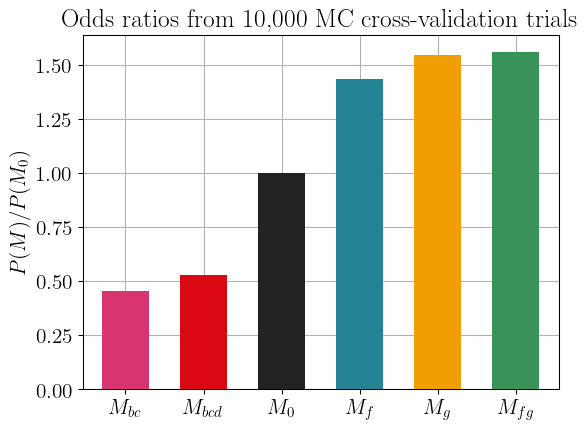

In [92]:
# Make a bar plot of the odds ratios calculated wrt M_0: P(M)/P(M_0)
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Use pandas' bar plotting method that sets the ticks and tick-labels for us.
# We specify the zorder here to have the grid show up behind the bars.
# The rot parameter forces the tick labels to be horizontal rather than vertical.
odds_ratios["odds_ratio (vs $M_0$)"].plot.bar(width=0.6, rot=0, color=MODEL_COLORS, zorder=3, ax=ax)
# Make a grid behind the bars (zorder 0 < 3)
ax.grid(zorder=0)
# Set the y-axis label and title. The x-axis ticks are already labeled for us by pandas.
ax.set_ylabel("$P(M) / P(M_0)$")
ax.set_title("Odds ratios from 10,000 MC cross-validation trials")
# Output the png for the slides (Google Slides doesn't support vector)
plt.savefig("odds.png")
plt.show()

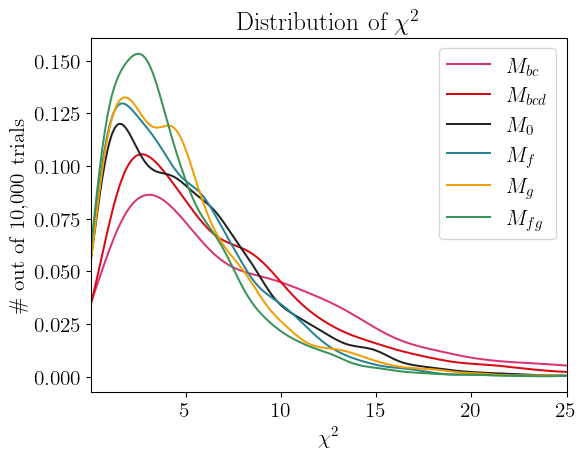

In [132]:
# Make a plot of the distributions of the chi^2 for each model, based on the scipy gaussian_kde
# function for smoothing
from scipy.stats import gaussian_kde

fig, ax = plt.subplots()

# Make the x locations of plotted points. 200 points is enough.
xs = np.linspace(0, 25, 200)

# For each model, do the KDE and plot the result
for i, (c, l) in enumerate(zip(MODEL_COLORS, MODEL_NAMES)):
    y = chi2_c[:, i]
    # Cut off the data at a reasonable value when doing the KDE otherwise a few failed curve_fits
    # will mess up the distribution entirely.
    pdf = gaussian_kde(y[y < 50])
    ax.plot(xs, pdf(xs), color=c, label=l)

# Set axis labels in latex
ax.set_xlabel(r"$\chi^2$")
ax.set_ylabel(r"\# out of 10,000 trials")
# Set the x-axis limits. Using 0.01 hides the redundant vertical line at 0.0
ax.set_xlim(0.01, 25)
# Set the plot title
ax.set_title(r"Distribution of $\chi^2$")
# Make the legend
ax.legend()
# Output the png for the slides (Google Slides doesn't support vector)
plt.savefig("chi2.png")
plt.show()